# 1. 模型性能回归图（Model performance regression plot）

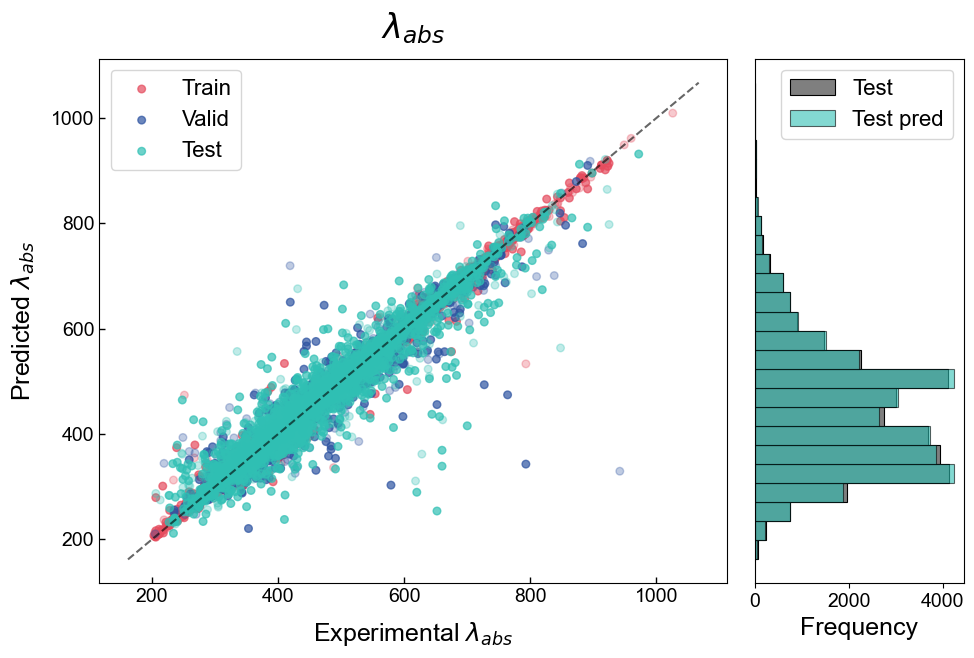

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# 文件名column表
files = ['./data/01_train_predictions_abs.csv', './data/01_valid_predictions_abs.csv', './data/01_test_predictions_abs.csv']
labels = ['Train', 'Valid', 'Test']
colors = ['#E54C5E', '#2E54A1', '#30C0B4']  # 不同的颜色
al = [0.7,0.7,0.3]

# 设置图形
fig = plt.figure(figsize=(10, 6.8))
gs = GridSpec(1, 2, width_ratios=[3, 1])  # 1行2column，第二column（柱状图）占1/4宽度
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 左侧：散点图
ax1 = fig.add_subplot(gs[0])

# 遍历每个文件，绘制散点图
for file, label, color in zip(files, labels, colors):
    data = pd.read_csv(file)
    ax1.scatter(data['abs'], data['abs_pred'], alpha=al, c=color, label=label, s=30)

# 设置坐标轴和标题
ax1.set_xlabel(r'Experimental $\lambda_{abs}$', labelpad=10, family='Arial')
ax1.set_ylabel(r'Predicted $\lambda_{abs}$', labelpad=10, family='Arial')
ax1.tick_params(axis='x', direction='in', length=4, width=1)
ax1.tick_params(axis='y', direction='in', length=4, width=1)

# 获取坐标轴范围
xmin, xmax = ax1.get_xlim()
ymin, ymax = ax1.get_ylim()

# 绘制y=x线（对角线）
ax1.plot([xmin, xmax], [xmin, xmax], color='black', linestyle='--', alpha=0.6)

# 去除网格
ax1.grid(False)
ax1.legend(prop={'size': 16, 'family': 'Arial'})
ax1.set_title(r'$\lambda_{abs}$', fontweight='bold', pad=15)

# 右侧：垂直柱状图
ax2 = fig.add_subplot(gs[1])

# 收集每个数据集的AM和AM_pred值，用于统计柱状图
am_values = []
am_pred_values = []

for file, label, color in zip(files, labels, colors):
    data = pd.read_csv(file)
    am_values.extend(data['abs'].dropna())
    am_pred_values.extend(data['abs_pred'].dropna())

# 计算AM和AM_pred的最小值和最大值，用于设定统一的bins
min_value = min(min(am_values), min(am_pred_values))
max_value = max(max(am_values), max(am_pred_values))

# 设置相同的bins
bins = 25
bin_range = [min_value, max_value]

# 绘制AM和AM_pred的直方图，设置为垂直柱状图（交换坐标轴）
ax2.hist(am_values, bins=bins, alpha=1, color='#7f7f7f', label='Test', orientation='horizontal', edgecolor='black', linewidth=0.8, range=bin_range)
ax2.hist(am_pred_values, bins=bins, alpha=0.6, color='#30C0B4', label='Test pred', orientation='horizontal', edgecolor='black', linewidth=0.8, range=bin_range)

# 设置柱状图标题和标签
ax2.set_xlabel('Frequency')
ax2.set_ylabel('')  # 去掉纵坐标标签
ax2.set_yticks([])  # 去掉纵坐标刻度
ax2.legend(loc='upper right', prop={'size': 16, 'family': 'Arial'})

# 调整布局
plt.tight_layout()

# 保存图像
plt.savefig('./figure/1_abs.png', dpi=600, bbox_inches='tight', format='png')
plt.show()


# 2. 消融图（Ablation plot）

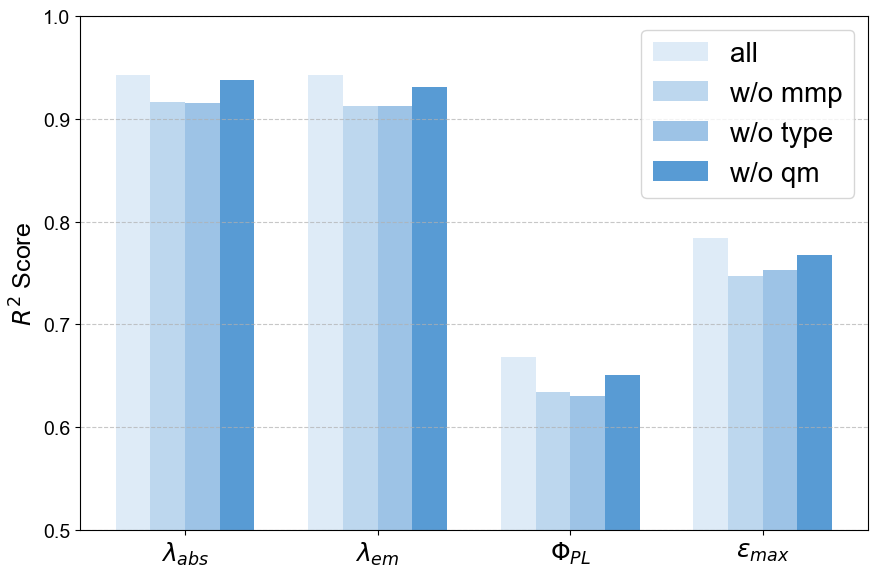

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 构造数据
data = {
    'Setting': ['all', 'w/o mmp', 'w/o type', 'w/o qm'],
    'λ_abs': [0.943, 0.916, 0.915, 0.938],
    'λ_em': [0.943, 0.912, 0.912, 0.931],
    'Φ_PL': [0.668, 0.634, 0.630, 0.651],
    'ε_max': [0.784, 0.747, 0.753, 0.768]
}

df = pd.DataFrame(data)

# 任务与位置
tasks = ['λ_abs', 'λ_em', 'Φ_PL', 'ε_max']
x = np.arange(len(tasks))
width = 0.18

# 自定义颜色
custom_colors = ['#DEEBF7', '#BDD7EE', '#9DC3E6', '#589BD4']  # 渐变蓝

# LaTeX格式任务标签：下标显示
tasks_latex = [r'$\lambda_{abs}$', r'$\lambda_{em}$', r'$\Phi_{PL}$', r'$\varepsilon_{max}$']

fig, ax = plt.subplots(figsize=(9, 6))

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


# 绘图
for i, setting in enumerate(df['Setting']):
    values = df.loc[i, tasks].values
    ax.bar(x + (i - 1.5) * width, values, width, label=setting, color=custom_colors[i])

# 设置标签与美化
ax.set_ylabel(r'$R^2$ Score', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(tasks_latex, fontsize=18)
ax.set_ylim(0.5, 1.0)

# 图例设置字体大小
legend = ax.legend(fontsize=20)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./figure/2_消融.png', dpi=600, bbox_inches='tight', format='png')
plt.show()


# 3. 隐藏层降维图（Hidden layer feature dimensionality reduction plot）

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Read data
df = pd.read_csv("./data/03_abs_test_features.csv")  # 替换为你的CSV文件路径

# 第一column为回归标签
labels = df.iloc[:, 0].values

# 后面所有column为特征
features = df.iloc[:, 1:].values

# 标准化特征
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# t-SNE降维
tsne = TSNE(n_components=2, random_state=42, perplexity=100)
tsne_result = tsne.fit_transform(features_scaled)

# 创建 DataFrame 存放结果
tsne_df = pd.DataFrame()
tsne_df["TSNE1"] = tsne_result[:, 0]
tsne_df["TSNE2"] = tsne_result[:, 1]
tsne_df["Label"] = labels


E:\Anaconda\envs\dye37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
E:\Anaconda\envs\dye37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


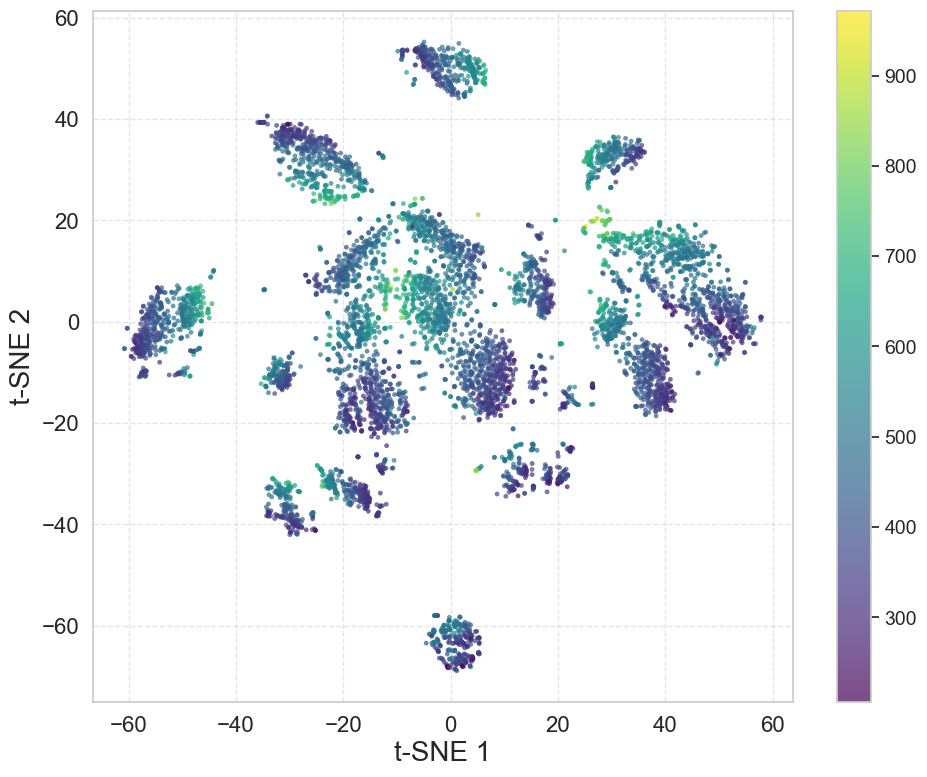

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置 seaborn 样式
sns.set(style="whitegrid")

# 创建图像
plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

scatter = plt.scatter(
    tsne_df["TSNE1"],
    tsne_df["TSNE2"],
    c=tsne_df["Label"],
    cmap="viridis",
    s=12,  # 缩小点
    edgecolor='none',  # 去除边框
    alpha=0.7
)

# 添加颜色条
cbar = plt.colorbar(scatter)
# cbar.set_label("Regression Value", fontsize=12)

# 设置标题和轴标签
# plt.title("t-SNE Projection Colored by Regression Value", fontsize=15)
plt.xlabel("t-SNE 1", fontsize=20)
plt.ylabel("t-SNE 2", fontsize=20)
plt.xticks(fontsize=16)  # 横坐标刻度值字体大小
plt.yticks(fontsize=16)  # 纵坐标刻度值字体大小

# 细节美化
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# 保存与展示
plt.savefig("./figure/3_abs.png", dpi=600)
plt.show()


# 4. LDS消融图（LDS ablation plot）

<Figure size 1000x800 with 0 Axes>

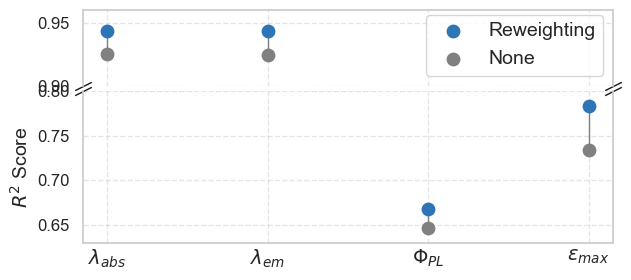

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
# 数据
tasks = ['$\lambda_{abs}$', '$\lambda_{em}$', r'$\Phi_{PL}$', r'$\varepsilon_{max}$']
alpha_values = [0.943, 0.943, 0.668, 0.784]
no_alpha_values = [0.925, 0.924, 0.647, 0.734]
x = np.arange(len(tasks))

plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 创建两个子图共享x轴
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6.5, 3),
                               gridspec_kw={'height_ratios': [1, 2]}, dpi=100)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13

# 设置断轴范围
ax1.set_ylim(0.9, 0.96)   # 上半部分：0.9 到 0.96
ax2.set_ylim(0.63, 0.8)   # 下半部分：0.63 到 0.8
# 绘制数据
for i in range(len(tasks)):
    # 虚线连接
    ax1.plot([x[i], x[i]], [no_alpha_values[i], alpha_values[i]],
             linestyle='-', color='gray', linewidth=1)
    ax2.plot([x[i], x[i]], [no_alpha_values[i], alpha_values[i]],
             linestyle='-', color='gray', linewidth=1)
    
    # 散点大小
    dot_size = 80
    # 上图中的散点
    ax1.scatter(x[i], alpha_values[i], color='#2E75B6', s=dot_size, label='Reweighting' if i == 0 else "", zorder=3)
    ax1.scatter(x[i], no_alpha_values[i], color='gray', s=dot_size, label='None' if i == 0 else "", zorder=3)
    
    # 下图中的散点
    ax2.scatter(x[i], alpha_values[i], color='#2E75B6', s=dot_size, zorder=3)
    ax2.scatter(x[i], no_alpha_values[i], color='gray', s=dot_size, zorder=3)


# 美化断轴：添加锯齿标记
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # 关闭上轴的刻度标签
ax2.xaxis.tick_bottom()

# 添加断裂符号
d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# 设置标签
ax2.set_xticks(x)
ax2.set_xticklabels(tasks, fontsize=14)
ax2.tick_params(axis='x', length=0)  # 去除横坐标刻度尺
ax2.set_ylabel(r"$R^2$ Score", fontsize=14)
# ax1.set_title("Effect of Alpha on Each Task (with Broken Y-axis)", fontsize=16)

# 图例
ax1.legend(loc='lower right', fontsize=14)

# 网格与布局
ax1.grid(True, linestyle='--', alpha=0.5)
ax2.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig("./figure/4_LDS.png", dpi=300)
plt.show()


# 5. 数据分布图（Data distribution plot）

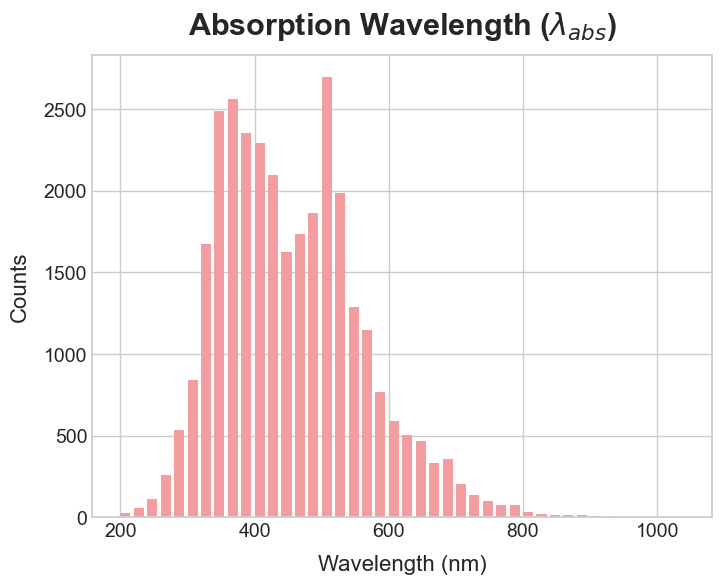

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os

# 设置字体为 Times New Roman，手动修改字号
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14  # 修改此处以设置整体的默认字体大小
rcParams['axes.titlesize'] = 22  # 设置标题的字体大小
rcParams['axes.labelsize'] = 14  # 设置坐标轴标签的字体大小
rcParams['xtick.labelsize'] = 14  # 设置 x 轴刻度的字体大小
rcParams['ytick.labelsize'] = 14  # 设置 y 轴刻度的字体大小

# 读取CSV文件，假设吸收波长column名为 'AM'
df = pd.read_csv('./data/05_FluoDB.csv')

# 提取吸收波长column
wavelengths = df['abs']

# 设置每隔 20nm 的区间范围
bar = 20
bins = range(int(wavelengths.min()) // bar * bar, int(wavelengths.max()) // bar * bar + 40, bar)
# 创建图形，调整图像比例
plt.figure(figsize=(8, 6))  # 设置宽度和高度


# 绘制条形图
plt.hist(wavelengths, bins=bins, edgecolor='none', alpha=1, width=15, color='#F39DA0')

# 添加标题和标签|
plt.title(r'Absorption Wavelength ($\lambda_{abs}$)', pad=15, fontweight='bold')
plt.xlabel('Wavelength (nm)', labelpad=10,fontsize=16)
plt.ylabel('Counts', labelpad=10,fontsize=16)
plt.tick_params(axis='x', length=0, width=1)  # 隐藏x轴刻度线
plt.tick_params(axis='y', direction='in', length=4, width=1)  # 保持y轴刻度线向内


# 保存图片到指定路径
plt.savefig(os.path.join('./figure/5_abs.png'), dpi=600, bbox_inches='tight', format='png')

# 显示图表
plt.show()


# 6. 量化信息和分子性质的相关性图（Correlation plot between quantized information and molecular properties）

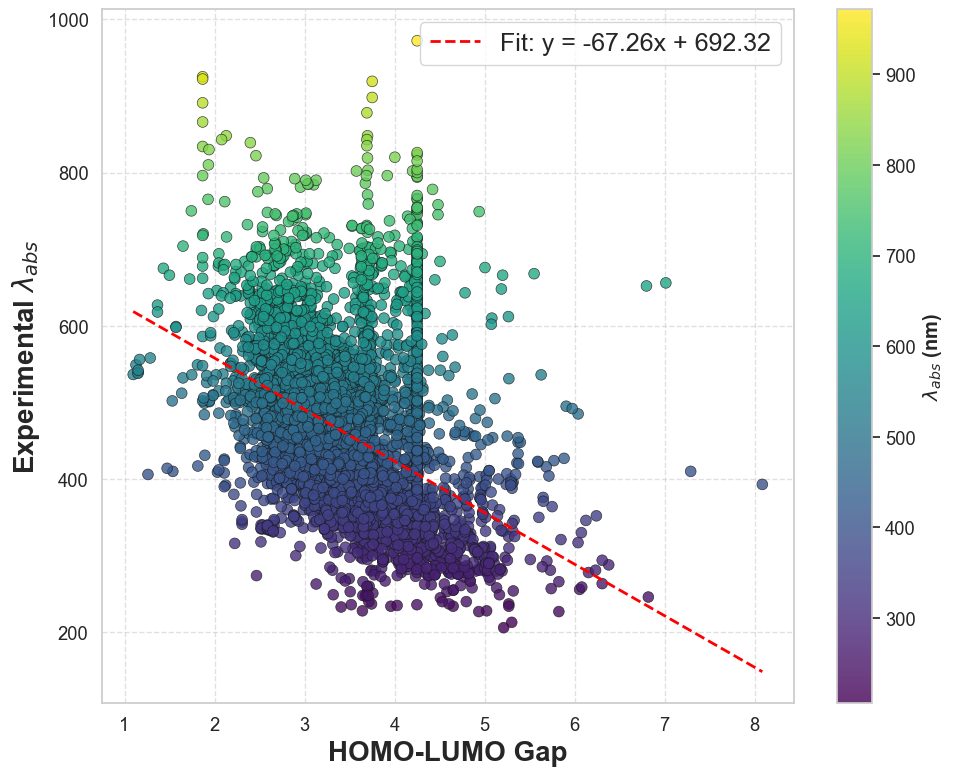

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['xtick.labelsize'] = 14  # 设置 x 轴刻度的字体大小
rcParams['ytick.labelsize'] = 14  # 设置 y 轴刻度的字体大小

# 设置图像风格
sns.set(style='whitegrid', font_scale=1.2)

# Read CSV file
df = pd.read_csv('./data/06_test_abs.csv')

# 提取数据
x = df['unimol_plus']
y = df['abs']

# 计算线性拟合
slope, intercept = np.polyfit(x, y, 1)
line_x = np.linspace(x.min(), x.max(), 100)
line_y = slope * line_x + intercept

# 创建图像
plt.figure(figsize=(10, 8))
sc = plt.scatter(x, y, c=y, cmap='viridis', s=60, alpha=0.8, edgecolors='k', linewidths=0.5)

# 拟合线
plt.plot(line_x, line_y, color='red', linestyle='--', linewidth=2, label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')

# 标签和标题
plt.xlabel('HOMO-LUMO Gap', weight='bold',fontsize=20)
plt.ylabel('Experimental $\lambda_{abs}$', weight='bold',fontsize=20)
# plt.title('Relationship between Quantum Descriptor and Absorption', weight='bold', fontsize=14)

# 添加色条
cbar = plt.colorbar(sc)
cbar.set_label('$\lambda_{abs}$ (nm)', weight='bold')

# 图例与美化
plt.legend(fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join('./figure/6_unimol_abs.png'), dpi=600, bbox_inches='tight', format='png')

plt.show()


# 7. LDS在不同区间的消融图（Ablation plot of LDS across different intervals）

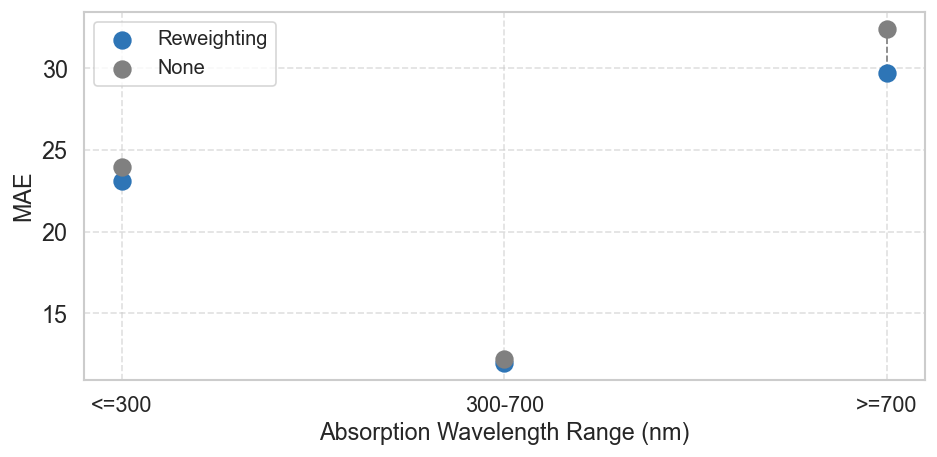

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# 设置区间标签
intervals = ['<=300', '300-700', '>=700']
x = np.arange(len(intervals))

# 有加权和无加权的 MAE 数值
mae_reweighting = [23.10, 11.98, 29.73]
mae_none = [23.97, 12.21, 32.44]

# 创建图像
plt.figure(figsize=(8, 4), dpi=120)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 13

# 绘制连接线与圆点
for i in range(len(intervals)):
    plt.plot([x[i], x[i]], [mae_none[i], mae_reweighting[i]], color='gray', linestyle='--', linewidth=1)
    plt.scatter(x[i], mae_reweighting[i], color='#2E75B6', s=100, label='Reweighting' if i == 0 else "", zorder=3)
    plt.scatter(x[i], mae_none[i], color='gray', s=100, label='None' if i == 0 else "", zorder=3)

# 设置坐标轴
plt.xticks(x, intervals, fontsize=13)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('Absorption Wavelength Range (nm)', fontsize=14)
# plt.title('MAE Comparison with and without Reweighting (LDS)', fontsize=15)

# 添加图例与网格
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 布局与展示
plt.tight_layout()
plt.savefig(os.path.join('./figure/7_LDS_区间.png'), dpi=600, bbox_inches='tight', format='png')
plt.show()
